In [1]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from utils import exploratory as expl

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

In [3]:
root_folder = os.path.relpath('../')
data_base = os.path.relpath('../data')
escolas = os.path.join(data_base, 'escolas')
docencias = os.path.join(data_base, 'docencias')
ideb = os.path.join(data_base, 'ideb')
municipios = os.path.join(data_base, 'municipios')
redes = os.path.join(data_base, 'redes')
schemas = os.path.join(root_folder, 'schemas/')

In [4]:
ano = 2015
ano_seguinte = 2017
target_option = 'total_iniciais'

## Calculando novas variáveis

In [6]:
escolas = expl.load_escolas(ano)

D:\Programs\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (10,12,52,59,61,63,64,68,69,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,98,99,102,104,105,107,108,113,121,124,125,126,127,128,129,130,136,152,155,191) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#### Relações entre quantidades de alunos e professores, funcionários, salas...

In [7]:
escolas['alunos_por_prof'] = escolas['num_estudantes'] / escolas['num_professores']
# Essas colunas causam muitas divisões por zero :/
# escolas['alunos_por_prof_fund_ai'] = escolas.num_estudantes_ensino_fund_anos_iniciais / escolas.num_professores_em_regencia_fund_ai
# escolas['alunos_por_prof_fund_af'] = escolas.num_estudantes_ensino_fund_anos_finais / escolas.num_professores_em_regencia_fund_af
# escolas['alunos_por_prof_medio'] = (escolas[[col for col in escolas.columns if 'num_estudantes_medio' in col]].sum(axis=1) 
#                                     / escolas.num_professores_em_regencia_ens_medio)
escolas['alunos_por_turma'] = escolas['num_estudantes'] / escolas['num_turmas']

escolas['turmas_por_professor'] = escolas['num_turmas'] / escolas['num_professores']
escolas['percentual_professores_em_regencia'] = escolas['num_professores_em_regencia'] / escolas['num_professores']

escolas['funcionarios_por_aluno'] = escolas['num_funcionarios'] / escolas['num_estudantes']
escolas['funcionarios_por_professor'] = escolas['num_funcionarios'] / escolas['num_professores']

escolas['num_alunos_por_sala_existente'] = escolas['num_estudantes'] / escolas['num_salas_existentes']
escolas['num_alunos_por_sala_utilizada'] = escolas['num_estudantes'] / escolas['num_salas_utilizadas']

In [8]:
escolas['percentual_evasao_abstencao_alunos'] = (escolas['num_matriculas'] - escolas['num_estudantes']) / escolas['num_matriculas']

### Ligando as informações de docência às escolas

In [9]:
docencias = expl.load_docencias(ano)

D:\Programs\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [10]:
docencias.head()

regiao unidade_federativa                municipio  \
0         Norte           Amazonas                  Humaitá   
1       Sudeste     Espírito Santo  Venda Nova do Imigrante   
2         Norte            Roraima                  Amajari   
3         Norte           Amazonas                Parintins   
4  Centro-Oeste        Mato Grosso          Barra do Garças   

  tp_dependencia_desc  tp_rede_publica rede_publica_desc tp_localizacao  \
0             Federal             True           Publica         Urbana   
1             Federal             True           Publica         Urbana   
2             Federal             True           Publica         Urbana   
3             Federal             True           Publica         Urbana   
4             Federal             True           Publica         Urbana   

  tp_categoria_escola_privada co_pessoa_fisica cod_municipio  \
0                         NaN     117849442201       1301704   
1                         NaN     115053300681       3205069   
2                         NaN     115046287136       1400027   
3                         NaN     115010027673       1303403   
4                         NaN     115070757317       5101803   

               ...                form_adequada_ciencias  \
0              ...                                 False   
1              ...                                 False   
2              ...                                 False   
3              ...                                 False   
4              ...                                 False   

  form_adequada_quimica form_adequada_fisica form_adequada_biologia  \
0                 False                False                  False   
1                 False                 True                  False   
2                 False                False                  False   
3                 False                False                  False   
4                 False                 True                  False   

  form_adequada_estudos_sociais form_adequada_historia  \
0                         False                  False   
1                         False                  False   
2                         False                  False   
3                         False                  False   
4                         False                  False   

   form_adequada_geografia form_adequada_sociologia form_adequada_filosofia  \
0                    False                    False                   False   
1                    False                    False                   False   
2                    False                    False                   False   
3                    False                    False                   False   
4                    False                    False                   False   

  form_adequada_ensino_religioso  
0                          False  
1                          False  
2                          False  
3                          False  
4                          False  

[5 rows x 72 columns]

In [11]:
escolas_docencias = escolas.merge(docencias, on='cod_escola_inep')

In [12]:
escolas_docencias = escolas_docencias.merge(docencias.groupby('cod_escola_inep', as_index=False)['num_disciplinas_ensina']
                                                     .sum(), on='cod_escola_inep')

In [13]:
escolas_docencias.head()

Unnamed: 0  cod_escola_inep regiao_x unidade_federativa_x  \
0           0         14006111    Norte              Roraima   
1           0         14006111    Norte              Roraima   
2           0         14006111    Norte              Roraima   
3           0         14006111    Norte              Roraima   
4           0         14006111    Norte              Roraima   

         mesoregiao microregiao municipio_x tp_dependencia  \
0  Norte de Roraima   Boa Vista   Boa Vista              1   
1  Norte de Roraima   Boa Vista   Boa Vista              1   
2  Norte de Roraima   Boa Vista   Boa Vista              1   
3  Norte de Roraima   Boa Vista   Boa Vista              1   
4  Norte de Roraima   Boa Vista   Boa Vista              1   

  tp_dependencia_desc_x tp_rede_publica_x            ...             \
0               Federal              True            ...              
1               Federal              True            ...              
2               Federal              True            ...              
3               Federal              True            ...              
4               Federal              True            ...              

  form_adequada_quimica form_adequada_fisica form_adequada_biologia  \
0                 False                False                  False   
1                 False                False                  False   
2                 False                False                  False   
3                 False                False                  False   
4                 False                False                  False   

  form_adequada_estudos_sociais form_adequada_historia  \
0                         False                  False   
1                         False                  False   
2                         False                  False   
3                         False                  False   
4                         False                  False   

  form_adequada_geografia  form_adequada_sociologia  form_adequada_filosofia  \
0                   False                     False                    False   
1                   False                     False                    False   
2                   False                     False                    False   
3                   False                     False                    False   
4                   False                     False                    False   

   form_adequada_ensino_religioso  num_disciplinas_ensina_y  
0                           False                      19.0  
1                           False                      19.0  
2                           False                      19.0  
3                           False                      19.0  
4                           False                      19.0  

[5 rows x 283 columns]

In [14]:
# num_disciplinas_ensina: média do número de disciplinas dadas por professor por escola 
escolas_docencias = escolas_docencias.merge(docencias.groupby('cod_escola_inep', as_index=False)['num_disciplinas_ensina'].mean(), on='cod_escola_inep')

# quantidade de professores que possuem ensino superior por escola
escolas_docencias = escolas_docencias.merge(docencias.groupby('cod_escola_inep', as_index=False)['tem_ensino_superior'].sum(), on='cod_escola_inep')

In [15]:
constant_columns = escolas_docencias.apply(lambda x: expl.is_constant(x))
escolas_docencias = escolas_docencias.drop(constant_columns[constant_columns==True].index,axis=1)

In [16]:
escolas_docencias.head()

Unnamed: 0  cod_escola_inep regiao_x unidade_federativa_x  \
0           0         14006111    Norte              Roraima   
1           0         14006111    Norte              Roraima   
2           0         14006111    Norte              Roraima   
3           0         14006111    Norte              Roraima   
4           0         14006111    Norte              Roraima   

         mesoregiao microregiao municipio_x tp_dependencia  \
0  Norte de Roraima   Boa Vista   Boa Vista              1   
1  Norte de Roraima   Boa Vista   Boa Vista              1   
2  Norte de Roraima   Boa Vista   Boa Vista              1   
3  Norte de Roraima   Boa Vista   Boa Vista              1   
4  Norte de Roraima   Boa Vista   Boa Vista              1   

  tp_dependencia_desc_x in_somente_matriculas_ac_ou_aee  \
0               Federal                           False   
1               Federal                           False   
2               Federal                           False   
3               Federal                           False   
4               Federal                           False   

           ...           form_adequada_biologia form_adequada_estudos_sociais  \
0          ...                            False                         False   
1          ...                            False                         False   
2          ...                            False                         False   
3          ...                            False                         False   
4          ...                            False                         False   

  form_adequada_historia form_adequada_geografia  form_adequada_sociologia  \
0                  False                   False                     False   
1                  False                   False                     False   
2                  False                   False                     False   
3                  False                   False                     False   
4                  False                   False                     False   

   form_adequada_filosofia  form_adequada_ensino_religioso  \
0                    False                           False   
1                    False                           False   
2                    False                           False   
3                    False                           False   
4                    False                           False   

   num_disciplinas_ensina_y  num_disciplinas_ensina  tem_ensino_superior_y  
0                      19.0                     1.0                     19  
1                      19.0                     1.0                     19  
2                      19.0                     1.0                     19  
3                      19.0                     1.0                     19  
4                      19.0                     1.0                     19  

[5 rows x 270 columns]

In [17]:
ideb_iniciais = expl.load_ideb('escolas', 'iniciais')
ideb_finais = expl.load_ideb('escolas', 'finais')

D:\Programs\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (64,65,67,68,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
D:\Programs\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [33]:
ideb_escolas = expl.merge_ideb_to_frame(ano, escolas_docencias, ideb_iniciais, ideb_finais)

D:\gammachallenge\notebooks\utils\exploratory.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ideb_iniciais_ano['diff_'+str(year)] = ideb_iniciais_ano['Ideb'+str(year+2)] - ideb_iniciais_ano['Ideb'+str(year)]
D:\gammachallenge\notebooks\utils\exploratory.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ideb_finais_ano['diff_'+str(year)] = ideb_finais_ano['Ideb'+str(year+2)] - ideb_finais_ano['Ideb'+str(year)]


In [34]:
ideb_escolas.columns

Index(['Unnamed: 0', 'cod_escola_inep', 'regiao_x', 'unidade_federativa_x',
       'mesoregiao', 'microregiao', 'municipio_x', 'tp_dependencia',
       'tp_dependencia_desc_x', 'in_somente_matriculas_ac_ou_aee',
       ...
       'form_adequada_ensino_religioso', 'num_disciplinas_ensina_y',
       'num_disciplinas_ensina', 'tem_ensino_superior_y', 'Ideb2015',
       'Ideb2017', 'diff_2015', 'Ideb2015_final', 'Ideb2017_final',
       'diff_2015_final'],
      dtype='object', length=276)

In [19]:
select_columns = [column for column in ideb_escolas.columns if not (
    column.startswith('num_estudantes')
    or column.startswith('ideb_')
    or column.startswith('num_matriculas')
    or column.startswith('num_funcionarios')
    or column.startswith('num_professores')
    or column.startswith('num_salas')
    or column.startswith('Nota')
    or column.startswith('Projecao')
    or column.startswith('etapa')
    or column.startswith('Indicador')
    or column.startswith('Unnamed')
    or column.endswith('_x')
    or column.endswith('_y')
    or column.endswith('_desc')
)]

drop_columns = [
    'nome_escola',
    'cod_ibge_uf',
    'mesoregiao',
    'microregiao',
    'in_dependencias_outras',
    'id_turma',
    'num_turmas',
    'cod_escola_inep',
    'co_pessoa_fisica',
    'co_lingua_indigena',
    'tp_rede_cod',
    'tp_rede_nome',
    'tp_etapa_ensino',
]

In [20]:
ideb_cols = [f"Ideb{ano}", f"Ideb{ano}_final",
             f"Ideb{ano_seguinte}", f"Ideb{ano_seguinte}_final",
             f"diff_{ano}", f"diff_{ano}_final"]

esc_ideb_clean = ideb_escolas[select_columns]
esc_ideb_clean = esc_ideb_clean.drop(drop_columns, axis=1)
esc_ideb_clean = esc_ideb_clean.dropna(subset=ideb_cols)

constant_columns = esc_ideb_clean.apply(lambda x: expl.is_constant(x))
esc_ideb_clean = esc_ideb_clean.drop(constant_columns[constant_columns==True].index, axis=1)

esc_ideb_clean['in_internet'] = esc_ideb_clean['in_internet'].astype('bool').fillna(False)

In [21]:
targets = {
    'total_iniciais': esc_ideb_clean.reset_index()[f"Ideb{ano}"],
    'total_finais': esc_ideb_clean.reset_index()[f"Ideb{ano}_final"],
    'diff_iniciais': esc_ideb_clean.reset_index()[f"diff_{ano}"],
    'diff_finais': esc_ideb_clean.reset_index()[f"diff_{ano}_final"]
}

esc_ideb_clean = esc_ideb_clean.drop(ideb_cols, axis=1)

In [22]:
esc_ideb_clean = expl.bool_to_int(esc_ideb_clean)

In [23]:
str_cols = [col for col, dtype in zip(esc_ideb_clean.columns, esc_ideb_clean.dtypes) if dtype == 'object']
df_enc = pd.get_dummies(esc_ideb_clean, columns=str_cols)

In [24]:
constant_columns = df_enc.apply(lambda x: expl.is_constant(x))
df_enc = df_enc.drop(constant_columns[constant_columns==True].index,axis=1)
df_enc = df_enc.fillna(df_enc.mean())

In [25]:
to_normalize = [x[0] for x in (df_enc.dtypes == 'float64').items() if x[1]]
scalers = {k: preprocessing.RobustScaler().fit(df_enc[k].values.reshape(-1, 1)) for k in to_normalize}
for column in to_normalize:
    df_enc[column] = scalers[column].transform(df_enc[column].values.reshape(-1, 1))

### Divisão entre treino e teste

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_enc, targets[target_option], test_size=0.2)

### Regressão Linear: Quais variáveis explicam melhor o objetivo?
Utilizamos uma regressão linear penalizada com norma 2.

In [26]:
ridge_reg = Ridge().fit(X_train, y_train)
pred = ridge_reg.predict(X_test)

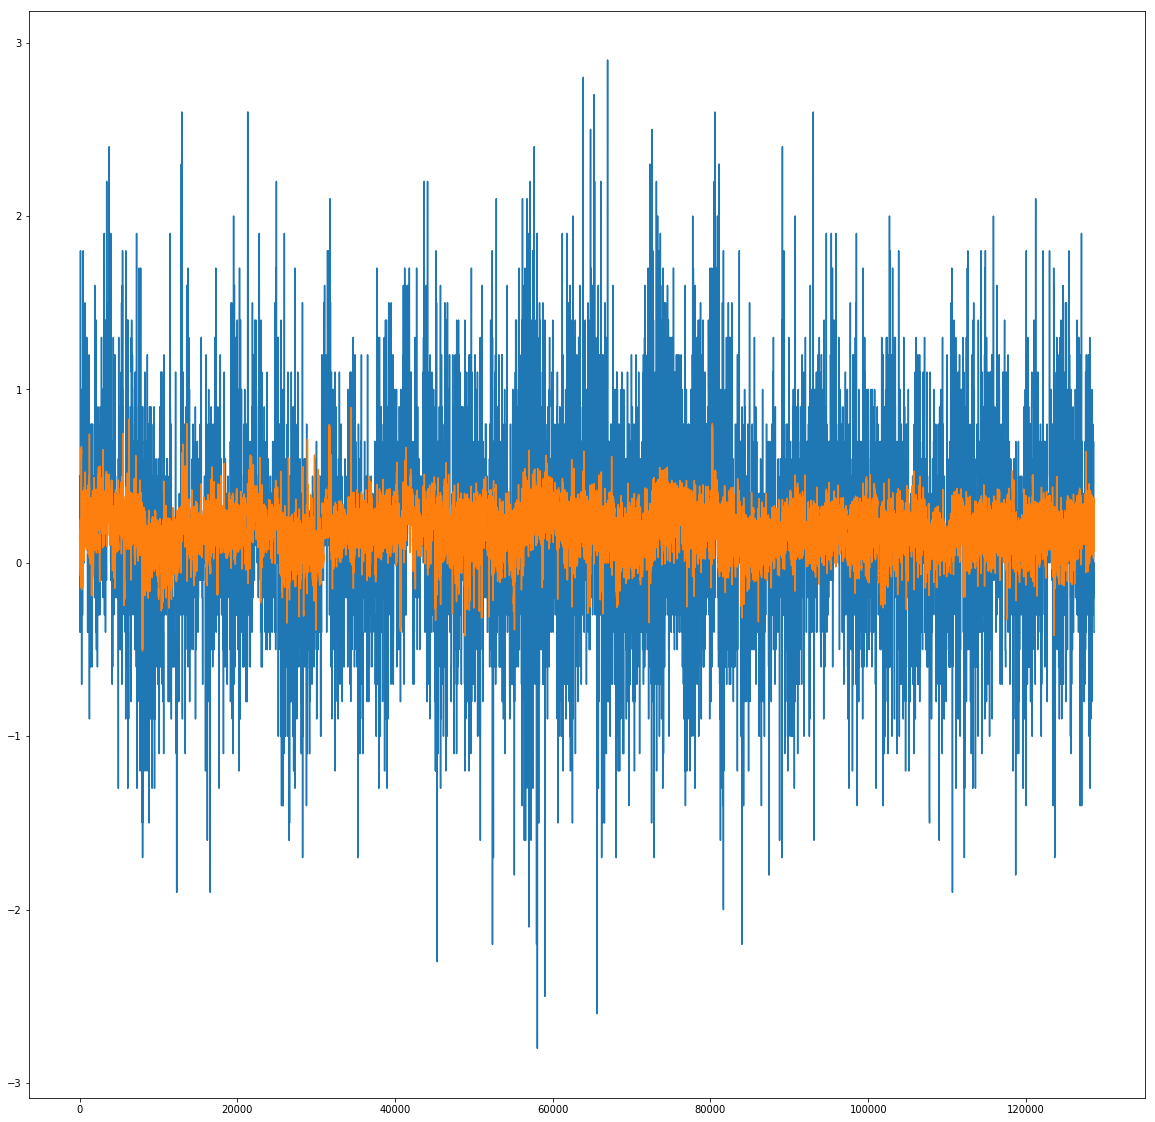

In [27]:
plt.plot(targets[target_option])
plt.plot(pred)

In [28]:
[(y, x) for x, y in sorted(zip(reg.coef_, df_enc.columns), reverse=True)]

[('in_alojam_aluno', -0.38673239495551437),
 ('in_local_func_socioeducativo', -0.3507688235271145),
 ('tp_ocupacao_galpao_3', -0.2399573844046874),
 ('tp_localizacao_diferenciada_3', -0.1737310374580285),
 ('in_esgoto_inexistente_False', -0.12999586000178584),
 ('tp_localizacao_diferenciada_1', -0.1277415682546021),
 ('in_energia_inexistente_True', -0.12144859240686919),
 ('tp_indigena_lingua_2', -0.11925465318513413),
 ('in_fundamental_ciclos', -0.09283366004089498),
 ('in_local_func_salas_empresa_False', -0.09028633049218195),
 ('in_agua_fonte_rio_True', -0.08789660199265957),
 ('num_equip_parabolica', -0.08229942858806888),
 ('tp_tipo_turma_4', -0.07790371842903533),
 ('in_energia_rede_publica_False', -0.07328111255921128),
 ('tp_tipo_turma_5', -0.07295717115786589),
 ('in_material_esp_quilombola', -0.07217248236826168),
 ('tp_localizacao_diferenciada_0', -0.07207414517062508),
 ('in_esgoto_fossa_False', -0.07100854700406006),
 ('in_comum_medio_normal', -0.06562980128399536),
 ('tp_

In [44]:
(df_enc.mean() * reg.coef_).sort_values(ascending=False)

in_predio_compartilhado_False          0.221799
in_energia_inexistente_False           0.121416
in_local_func_predio_escolar           0.098012
in_agua_fonte_rio_False                0.087386
in_energia_rede_publica_True           0.073161
in_local_func_unid_prisional_False     0.059114
in_energia_outros_False                0.058184
tp_indigena_lingua_0                   0.056555
in_educacao_indigena_False             0.056555
in_material_esp_nao_utiliza            0.053044
in_equip_som                           0.046033
in_internet                            0.043159
docente_em_regencia                    0.034946
in_esgoto_fossa_True                   0.032588
in_esgoto_rede_publica_True            0.031007
in_despensa                            0.025050
in_equip_parabolica_True               0.021392
in_laboratorio_informatica_True        0.020766
in_secretaria                          0.020136
tp_ocupacao_predio_escolar_1           0.019868
in_lixo_coleta_periodica_True          0

### Tentando predizer o IDEB ou a sua variação
Enquanto as regressões lineares são úteis para entender a importância de cada variável e seu
impacto positivo ou negativo na saída, esses modelos costumam não ter desempenhos muito
fascinantes por terem formulação não muito flexível (vide linear).

Um modelo de regressão mais flexível e que possibilita alguma compreensão da importância das 
variáveis é o modelo de árvores de regressão, e além desse o modelo de ensemble de árvores de
regressão, implementado no `RandomForestRegressor`. Usaremos esse modelo para tentar predizer
com melhor precisão nosso objetivo.

In [35]:
regr = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=100, n_jobs=2)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [36]:
predr = regr.predict(X_test)

In [37]:
regr.score(X_test, y_test)

0.933067830832275

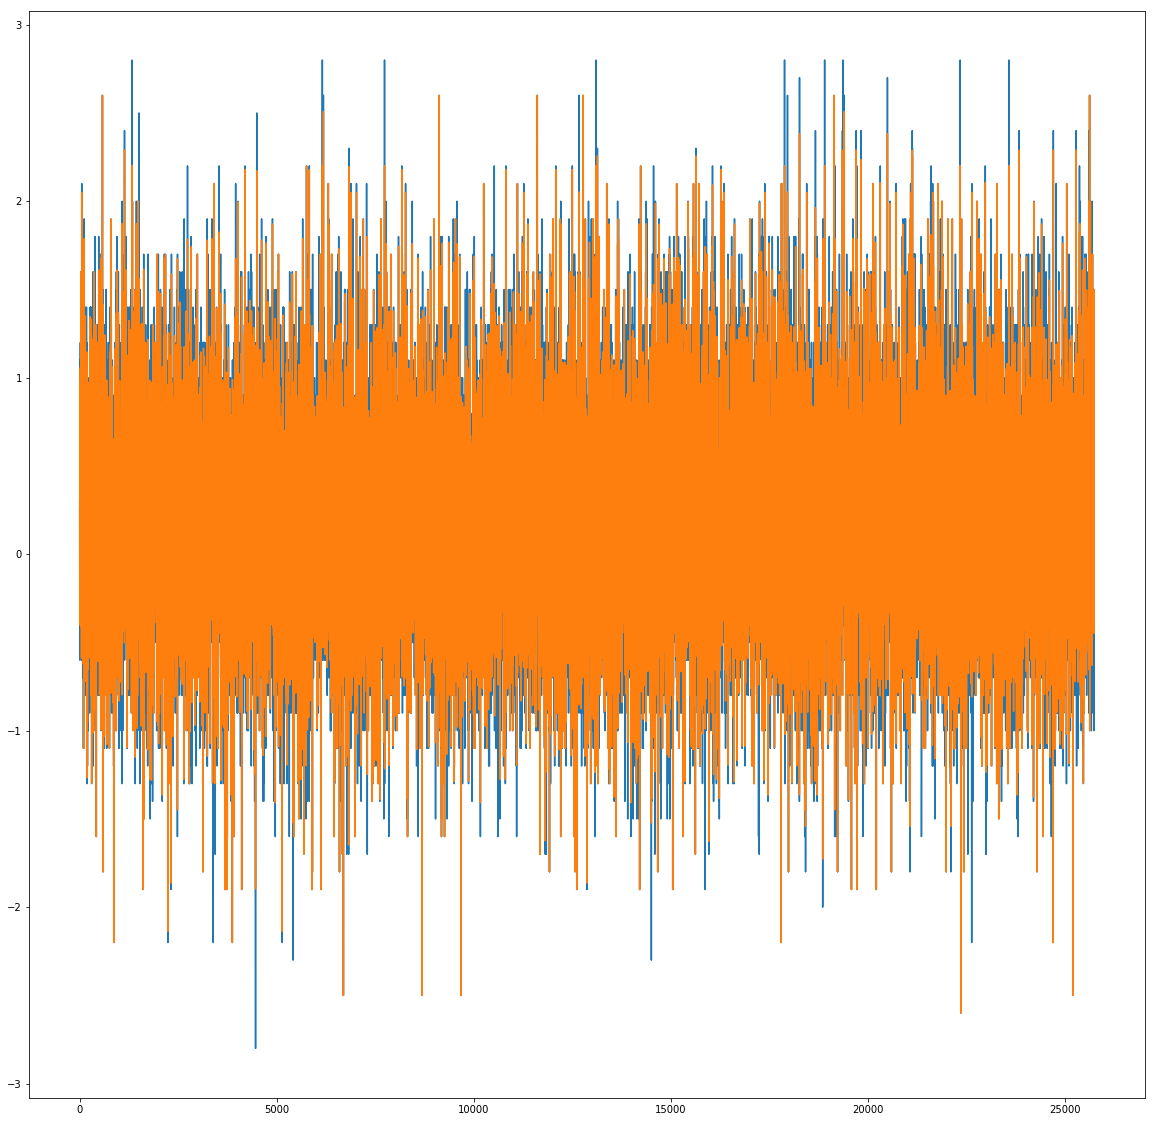

In [38]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(predr)

In [43]:
[(y, x) for x, y in sorted(zip(regr.feature_importances_, X_test.columns), reverse=True)]

[('turmas_por_professor', 0.05381533865719338),
 ('alunos_por_prof', 0.051183920336054116),
 ('funcionarios_por_aluno', 0.04989884534532456),
 ('funcionarios_por_professor', 0.04862952071478405),
 ('num_disciplinas_ensina', 0.0480805070705794),
 ('num_alunos_por_sala_existente', 0.04792200199315068),
 ('num_alunos_por_sala_utilizada', 0.047013796069386785),
 ('alunos_por_turma', 0.04639077243930976),
 ('percentual_evasao_abstencao_alunos', 0.04437779709112775),
 ('num_comp_aluno', 0.036747761687917796),
 ('num_computador', 0.03609766829668788),
 ('percentual_professores_em_regencia', 0.03098781906131826),
 ('num_comp_administrativo', 0.030432226253161873),
 ('num_equip_som', 0.021969283261908237),
 ('num_equip_multimidia', 0.02062899174320364),
 ('num_equip_impressora', 0.019740586925348417),
 ('num_equip_tv', 0.01853257126898358),
 ('num_equip_dvd', 0.015346838682412076),
 ('num_equip_foto', 0.013724530996384572),
 ('num_equip_copiadora', 0.013034632163039466),
 ('num_equip_impressora